In [1]:
%matplotlib notebook

import tkinter
import matplotlib
import platform
if platform.system() not in ['Linux', 'Darwin'] and not platform.system().startswith('CYGWIN'):
    matplotlib.use('TKAgg')
import matplotlib.pyplot as plt
from IPython import display


# 鑑黃大師 (pytorch)

In [2]:
import glob
import os
import cv2
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *

trident 0.4.3
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Using pillow image backend.
Pillow version:6.2.1.
Pytorch version:1.4.0.


![Alt text](../images/porndetector.jpg)

![Alt text](../images/pornclass.jpg)

In [3]:
dataset=load_examples_data('nsfw')
dataset.image_transform_funcs=[
    random_adjust_gamma(gamma=(0.8,1.2)),
    #隨機調整圖片明暗gamma 0.6~1.4之間
    random_adjust_contast(scale=(0.8, 1.2)),
    #隨機調整圖片對比度
    random_adjust_hue(),
    #隨機調整色相
    add_noise(intensity=np.random.choice(np.arange(0.001,0.1,0.0005))),
    #隨機加入噪音
    random_center_crop(224,224,scale=(0.9,1.1)),
    normalize(0, 255),  
    normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]

#數據集的圖片處理流程image_transform_funcs為標準imagenet標準化
#加上隨機調整色相random_adjust_hue以及隨機等比例縮放中心裁切random_center_crop

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
training images: 10001  test images:5746
Mapping class_names  in en-us   success, total 5 class names added.
Mapping class_names  in zh-tw   success, total 5 class names added.
Mapping class_names  in zh-cn   success, total 5 class names added.


![Alt text](../images/nsfw_data.jpg)

![Alt text](../images/EfficientNet.jpg)

In [4]:
#獲取EfficientNet-B0預訓練模型
#將全連接層長度改為5
effb0=EfficientNetB0(include_top=True,
             pretrained=True,
             input_shape=(3,224,224),
             classes=5)

#只開放全連接層以及最後一組Efficient Block開放學習
effb0.model.trainable=False
effb0.model.fc.trainable=True
effb0.model.block7a.trainable=True


1364it [00:00, 1383897.11it/s]
0.00B [00:01, ?B/s]


model file is already existing, donnot need download again.


C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'trident.backend.pytorch_backend.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'trident.layers.pytorch_blocks.Conv2d_Block' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
C:\Anaconda3\envs\azuremlenv\lib\site-packages\torch\serialization.py:593: SourceChangeWarning: source code of class 'trident.layers.pytorch_layers.DepthwiseConv2d' has changed. you can retrieve the original source

4013953 parameters have set untrainable
6405 parameters have set trainable
717232 parameters have set trainable


In [5]:
#召回率
def recall(output,target):
    input_tensor=output.clone().detach()
    target_tensor=target.clone().detach()
    input_tensor=argmax(input_tensor,1).squeeze() #將預測結果透過argmax，產生類別的判斷
    input_tensor=input_tensor.eq(3).float() #檢查那些預測結果是3(色情圖片)
    target_tensor=target_tensor.eq(3).float() #檢查那些答案是3(色情圖片)
    return (input_tensor*target_tensor).sum()/max(target_tensor.sum(),1)
#input_tensor*target_tensor兩個相乘結果為1，則表示實際是色情圖片且正確被預測
#除以所有的色情圖片總數target_tensor.sum()就可以獲得召回率

In [6]:
class CustomCallback(CallbackBase):
    def __init__(self):
        super(CustomCallback, self).__init__()
    def on_epoch_start(self, training_context):
        if training_context['current_epoch']==2:
            training_context['current_model'].block6d.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==10:
            training_context['current_model'].block6c.trainable=True #透過training_context切換模型指定層的trainable狀態
        if training_context['current_epoch']==15:
            training_context['current_model'].block6b.trainable=True #透過training_context切換模型指定層的trainable狀態
    

In [7]:
effb0=effb0\
    .with_optimizer(optimizer='Ranger',lr=1e-3,betas=(0.9, 0.999))\
    .with_loss(CrossEntropyLoss)\
    .with_loss(F1ScoreLoss,name='f1_score')\
    .with_metric(accuracy,name='accuracy')\
    .with_metric(recall,name='recall')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_model_save_path('Models/effb0_v2.pth')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='accuracy',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_callbacks(CustomCallback())

#指定優化器(使用Ranger)
#設定損失函數(交叉熵)
#設定評估函數(正確率與召回率)
#設定l2正則化
#設定max_min_norm權重約束
#指定模型存檔位置
#指定學習速率調整機制


effb0.summary()
#檢視模型結構

CrossEntropyLoss signature:['output', 'target']
f1_score signature:['output', 'target']
accuracy signature:['output', 'target']
recall signature:['output', 'target']
--------------------------------------------------------------------------------------------------------------------------------
                Layer (type)                      Output Shape            Weight           Bias    Param #     FLOPS #   
stem.conv                                     [-1, 32, 112, 112]    [32, 3, 3, 3]                  864       21663488.0  
stem.norm                                     [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
stem                                          [-1, 32, 112, 112]                                   0         0.0         
block1a.0.conv                                [-1, 32, 112, 112]    [32, 1, 3, 3]                  288       7212800.0   
block1a.0.norm                                [-1, 32, 112, 112]    [32]                 [32]  

In [8]:
#設定學習計畫
#指定資料提供者
#跑10個epoach
#minibatch_size為16
#每10個批次列印一次訓練進度
#每100個批次顯示一次loss_metric_curve
#每10個批次存檔一次
plan=TrainingPlan()\
    .add_training_item(effb0)\
    .with_data_loader(dataset)\
    .repeat_epochs(30)\
    .within_minibatch_size(16)\
    .print_progress_scheduling(20,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=100,unit='batch',imshow=True)\
    .save_model_scheduling(10,unit='batch')

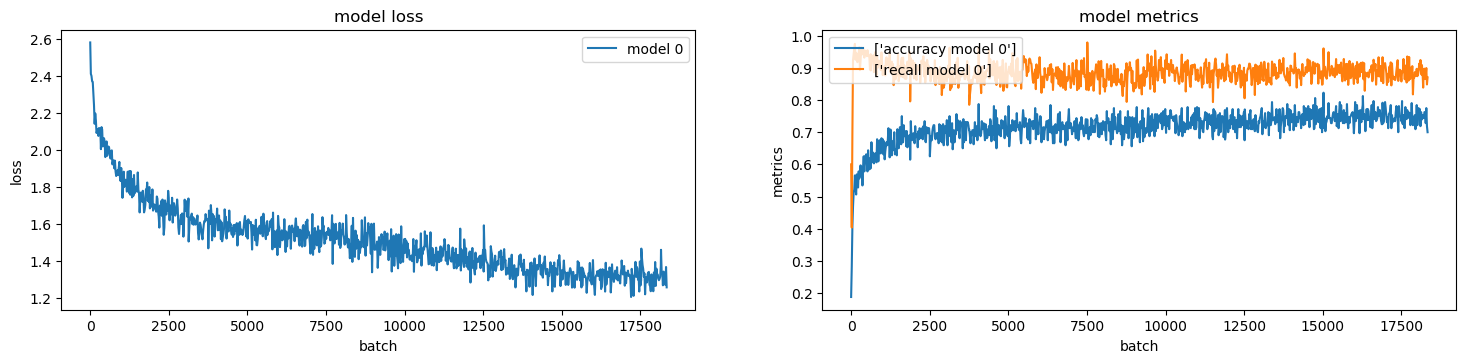

model 0          Step: 17s732ms | Loss: 1.311   | accuracy: 74.687% ,recall: 86.638%  | learning rate: 3.125e-05 | epoch: 29 ( 200/626 )
model 0          Step: 16s862ms | Loss: 1.299   | accuracy: 71.875% ,recall: 88.505%  | learning rate: 3.125e-05 | epoch: 29 ( 220/626 )
model 0          Step: 16s891ms | Loss: 1.356   | accuracy: 78.750% ,recall: 89.252%  | learning rate: 3.125e-05 | epoch: 29 ( 240/626 )
model 0          Step: 17s224ms | Loss: 1.286   | accuracy: 78.750% ,recall: 91.858%  | learning rate: 3.125e-05 | epoch: 29 ( 260/626 )
model 0          Step: 16s844ms | Loss: 1.292   | accuracy: 73.125% ,recall: 91.273%  | learning rate: 3.125e-05 | epoch: 29 ( 280/626 )


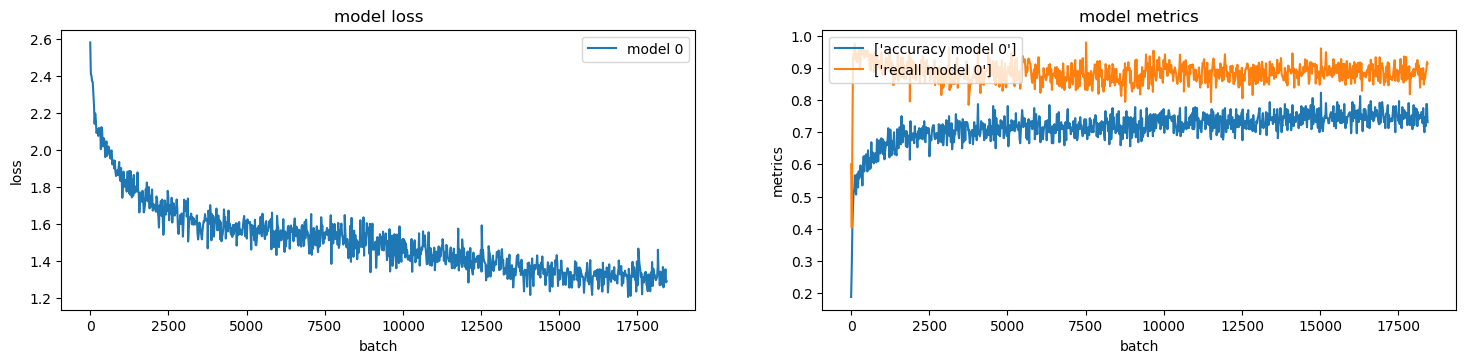

model 0          Step: 17s960ms | Loss: 1.248   | accuracy: 75.000% ,recall: 88.984%  | learning rate: 3.125e-05 | epoch: 29 ( 300/626 )
model 0          Step: 16s976ms | Loss: 1.315   | accuracy: 75.000% ,recall: 88.346%  | learning rate: 3.125e-05 | epoch: 29 ( 320/626 )
model 0          Step: 17s60ms  | Loss: 1.296   | accuracy: 78.438% ,recall: 91.980%  | learning rate: 3.125e-05 | epoch: 29 ( 340/626 )
model 0          Step: 16s883ms | Loss: 1.307   | accuracy: 73.438% ,recall: 87.475%  | learning rate: 3.125e-05 | epoch: 29 ( 360/626 )
model 0          Step: 16s928ms | Loss: 1.224   | accuracy: 76.562% ,recall: 92.250%  | learning rate: 3.125e-05 | epoch: 29 ( 380/626 )


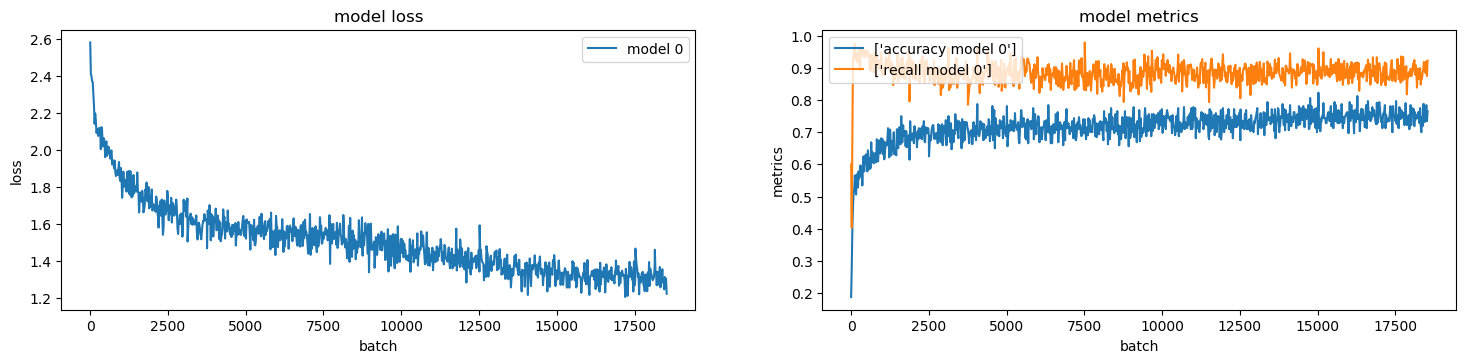

model 0          Step: 17s922ms | Loss: 1.317   | accuracy: 74.687% ,recall: 86.584%  | learning rate: 3.125e-05 | epoch: 29 ( 400/626 )
model 0          Step: 16s789ms | Loss: 1.269   | accuracy: 72.188% ,recall: 86.119%  | learning rate: 3.125e-05 | epoch: 29 ( 420/626 )
model 0          Step: 16s866ms | Loss: 1.265   | accuracy: 80.000% ,recall: 89.368%  | learning rate: 3.125e-05 | epoch: 29 ( 440/626 )
model 0          Step: 16s945ms | Loss: 1.286   | accuracy: 72.812% ,recall: 88.389%  | learning rate: 3.125e-05 | epoch: 29 ( 460/626 )
model 0          Step: 17s223ms | Loss: 1.395   | accuracy: 73.750% ,recall: 87.317%  | learning rate: 3.125e-05 | epoch: 29 ( 480/626 )


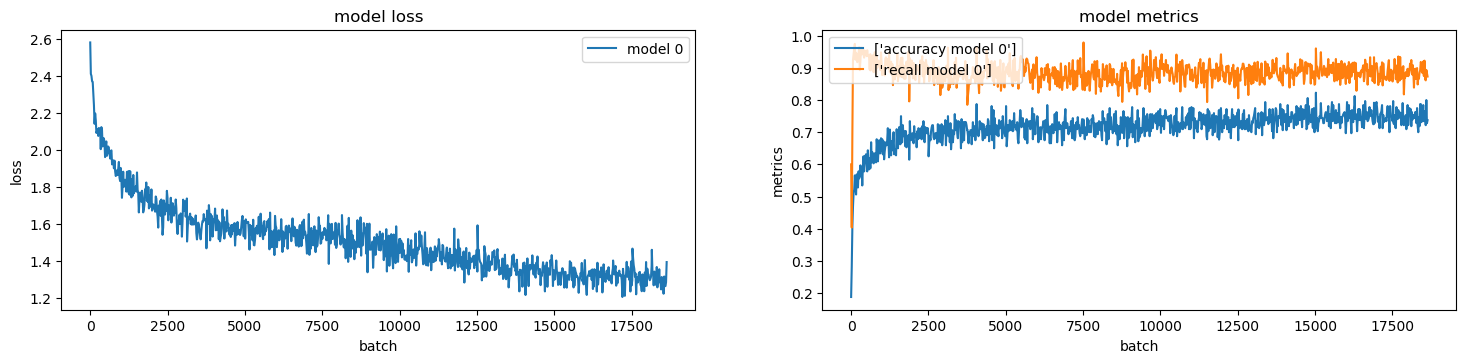

model 0          Step: 17s720ms | Loss: 1.340   | accuracy: 74.063% ,recall: 93.083%  | learning rate: 3.125e-05 | epoch: 29 ( 500/626 )
model 0          Step: 16s880ms | Loss: 1.374   | accuracy: 71.250% ,recall: 86.934%  | learning rate: 3.125e-05 | epoch: 29 ( 520/626 )
model 0          Step: 16s979ms | Loss: 1.332   | accuracy: 74.063% ,recall: 89.194%  | learning rate: 3.125e-05 | epoch: 29 ( 540/626 )
model 0          Step: 16s855ms | Loss: 1.273   | accuracy: 74.375% ,recall: 87.375%  | learning rate: 3.125e-05 | epoch: 29 ( 560/626 )
model 0          Step: 16s924ms | Loss: 1.351   | accuracy: 72.500% ,recall: 87.521%  | learning rate: 3.125e-05 | epoch: 29 ( 580/626 )


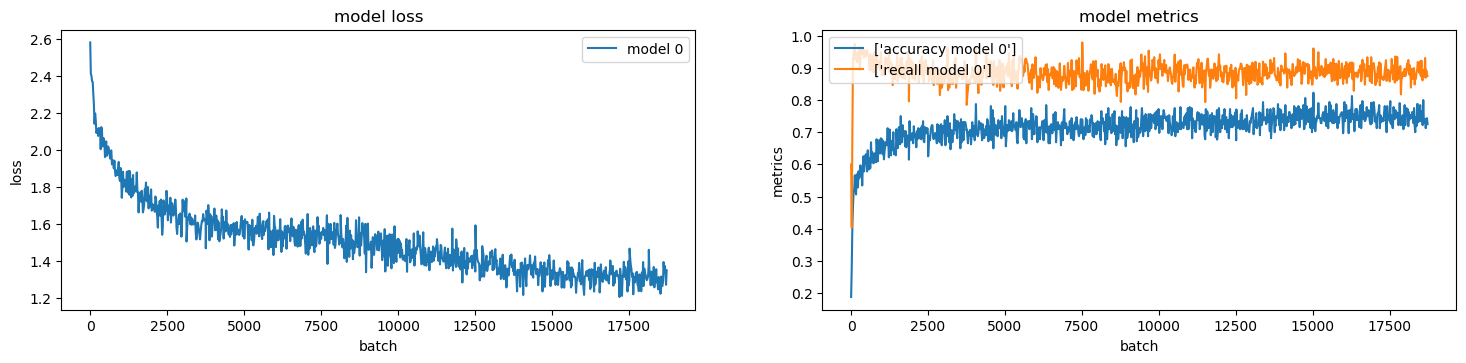

model 0          Step: 18s263ms | Loss: 1.306   | accuracy: 76.562% ,recall: 90.571%  | learning rate: 3.125e-05 | epoch: 29 ( 600/626 )
learning rate changed! ( form 3.125e-05 to 1.563e-05)

Epoch 00029: ReduceLROnPlateau reducing learning rate to 1.5625e-05.
model 0          Step: 16s885ms | Loss: 1.310   | accuracy: 80.625% ,recall: 92.696%  | learning rate: 1.563e-05 | epoch: 29 ( 620/626 )


In [9]:
#執行訓練
plan.start_now()

In [17]:
effb0.class_names=dataset.class_names['zh-tw']

OrderedDict([('繪畫', (0, 0.3747398)), ('中性', (2, 0.34870285)), ('色情', (3, 0.27654466))])


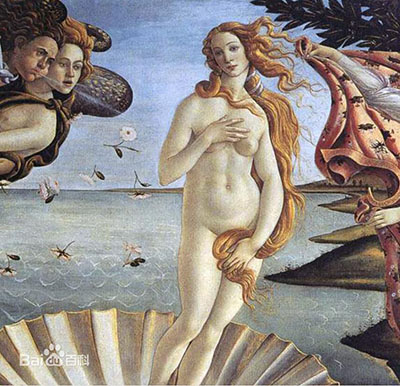

In [18]:
img=read_image('../images/venus.jpg')
print(effb0.infer_single_image('../images/venus.jpg',3))
img

OrderedDict([('中性', (2, 0.9999975)), ('性感', (4, 2.002742e-06)), ('色情', (3, 4.323038e-07))])


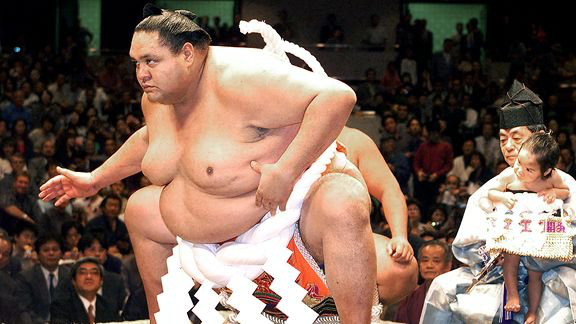

In [20]:
img=read_image('../images/sumo.jpg')
print(effb0.infer_single_image('../images/sumo.jpg',3))
img

OrderedDict([('性感', (4, 0.9840717)), ('色情', (3, 0.015810803)), ('中性', (2, 0.00011636494))])


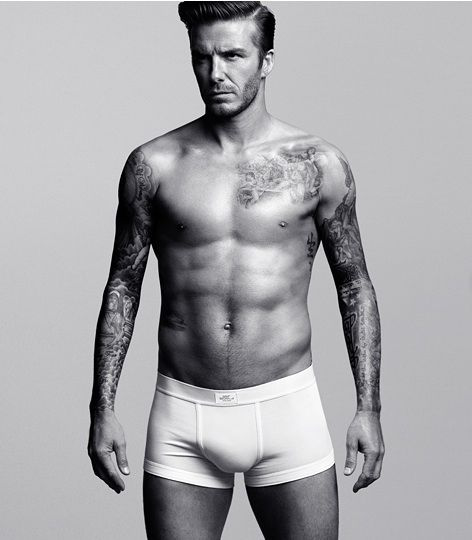

In [21]:
img=read_image('../images/beckham.jpg')
print(effb0.infer_single_image('../images/beckham.jpg',3))
img

OrderedDict([('色情', (3, 0.99790907)), ('性感', (4, 0.002086893)), ('色情漫畫', (1, 4.040722e-06))])


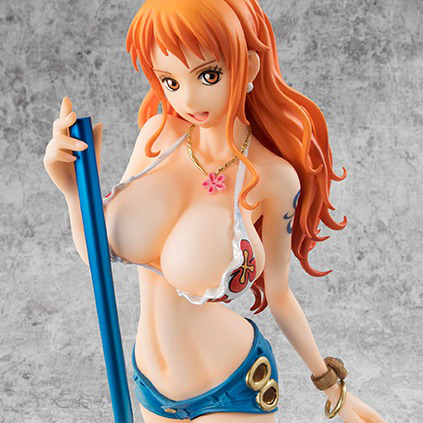

In [22]:
img=read_image('../images/nami.jpg')
print(effb0.infer_single_image('../images/nami.jpg',3))
img

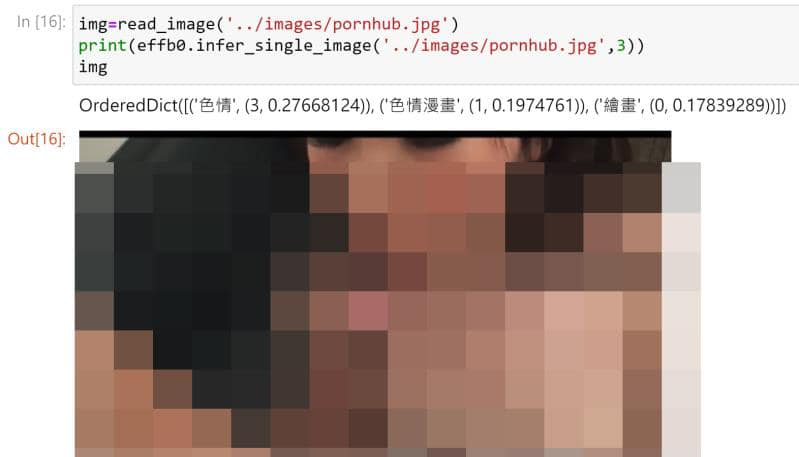

In [23]:
img=read_image('../images/pornhub.jpg')
img